## Дипломный проект
### Учебный кейс
### «Модель прогнозирования стоимости жилья для агентства недвижимости»

Продолжение.

In [1]:
# импорт необходимых библиотек
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression

from catboost import CatBoostRegressor

import category_encoders as ce

import optuna

import pickle

Загрузим датасет.

In [2]:
df = pd.read_csv('data/baseline.zip')
df.head()

,status,baths,fireplace,sqft,beds,state,MlsId,target,private_pool,property_type,city_2,stories_2,Heating,Cooling,Parking,lotsize,age_of_the_remodeled,schools_av_rating,schools_av_distance,schools_av_grades
0,FOR SALE,3.5,1,2900.0,4.0,NC,1,418000.0,0,SINGLE FAMILY,SOUTHERN PINES,2.0,AIR,0,0,0.0,5.0,3.625,5.538,0.342
1,FOR SALE,3.0,0,1947.0,3.0,WA,1,310000.0,0,SINGLE FAMILY,SPOKANE VALLEY,2.0,NO DATA,0,0,5828.0,5.0,3.000,1.327,0.444
2,FOR SALE,3.0,0,1807.0,3.0,FL,1,5000.0,0,LAND,PALM BAY,0.0,NO DATA,0,0,10019.0,39.0,4.667,4.080,0.311
3,FOR SALE,2.0,0,897.0,2.0,PA,1,209000.0,0,TOWNHOUSE,PHILADELPHIA,2.0,AIR,1,0,680.0,104.0,4.667,1.778,0.311
4,FOR SALE,3.0,0,1507.0,3.0,FL,1,181500.0,0,FLORIDA,POINCIANA,1.0,ELECTRIC,1,0,0.0,18.0,2.000,3.825,0.600


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286514 entries, 0 to 286513
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                286514 non-null  object 
 1   baths                 286514 non-null  float64
 2   fireplace             286514 non-null  int64  
 3   sqft                  286514 non-null  float64
 4   beds                  286514 non-null  float64
 5   state                 286514 non-null  object 
 6   MlsId                 286514 non-null  int64  
 7   target                286514 non-null  float64
 8   private_pool          286514 non-null  int64  
 9   property_type         286514 non-null  object 
 10  city_2                286514 non-null  object 
 11  stories_2             286514 non-null  float64
 12  Heating               286514 non-null  object 
 13  Cooling               286514 non-null  int64  
 14  Parking               286514 non-null  int64  
 15  

Разделим датасет

In [4]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

Закодируем категориальные признаки.

In [5]:
# Binary Encoding
columns_to_change = ['property_type', 'state', 'city_2']

# кодируем
bin_encoder = ce.BinaryEncoder(cols=columns_to_change)
type_bin = bin_encoder.fit_transform(X_train[columns_to_change])
X_train = pd.concat([X_train, type_bin], axis=1)

# сразу удалим лишнее
X_train = X_train.drop(columns=columns_to_change)

# тестовые данные
type_bin = bin_encoder.transform(X_test[columns_to_change])
X_test = pd.concat([X_test, type_bin], axis=1)

# сразу удалим лишнее
X_test = X_test.drop(columns=columns_to_change)


In [6]:
# OneHot Encoding
columns_to_change = ['status', 'Heating']

# кодируем
hot_encoder = ce.OneHotEncoder(cols=columns_to_change)
type_hot = hot_encoder.fit_transform(X_train[columns_to_change])
X_train = pd.concat([X_train, type_hot], axis=1)

# сразу удалим лишнее
X_train = X_train.drop(columns=columns_to_change)

# тестовые данные
type_hot = hot_encoder.transform(X_test[columns_to_change])
X_test = pd.concat([X_test, type_hot], axis=1)

# сразу удалим лишнее
X_test = X_test.drop(columns=columns_to_change)


Стандартизируем

In [7]:
scaler = preprocessing.StandardScaler().set_output(transform='pandas')
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Напомним метрик которые у нас получились на базовой модели.  
**R2:**  
Train: 0.369  
Test: 0.370  
**MAPE:**  
Train: 10.893  
Test: 4.460  
Сейчас нам нужно улучшить показатели базовой модели.

In [8]:
# заведем список для показателей моделей
# - модель
# - R2 на тренировочных данных
# - R2 на тестовых данных
# - MAPE на тренировочных данных
# - MAPE на тестовых данных
model_indicators = [['base', 0.369, 0.370, 10.893, 4.460]]

### Полиномиальная регрессия

In [9]:
# отберем 30 наиболее значимых признаков
# т.к. расчет с использованияем всех признаков приводил к нехватке памяти
selector = SelectKBest(f_regression, k=30).set_output(transform='pandas')
X_train_30 = selector.fit_transform(X_train_scaled, y_train)
X_test_30 = X_test_scaled[X_train_30.columns]

In [10]:
# сгенерируем признаки
pl = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
pl.fit(X_train_30)

X_train_poly = pl.transform(X_train_30)
X_test_poly = pl.transform(X_test_30)

In [11]:
# воспользуемся L2 регуляризацией, чтобы избежать переобучения
lr = linear_model.Ridge(alpha=0.2)
lr.fit(X_train_poly, y_train)

Ridge(alpha=0.2)

In [12]:
y_train_pred = lr.predict(X_train_poly)
y_test_pred = lr.predict(X_test_poly)

In [13]:
# считаем метрики
r2_lr_train = metrics.r2_score(y_train, y_train_pred)
r2_lr_test = metrics.r2_score(y_test, y_test_pred)
mape_lr_train = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
mape_lr_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
print('Метрики модели полиномиальная регрессия:')
print('R2:')
print(f'Train: {r2_lr_train :.3f}')
print(f'Test: {r2_lr_test :.3f}')
print('MAPE:')
print(f'Train: {mape_lr_train :.3f}')
print(f'Test: {mape_lr_test :.3f}')

# запишем показатели
model_indicators.append(['poly', r2_lr_train, r2_lr_test, mape_lr_train, mape_lr_test])

Метрики модели полиномиальная регрессия:
R2:
Train: 0.541
Test: 0.539
MAPE:
Train: 10.950
Test: 5.239


Видим, что R2 вырос, но думаю, что это не предел. Переходим к другим моделям.

### Дерево решений

Будем сразу подбирать гиперпараметры модели. Для этого воспользуемся фреймворком Optuna. Он специально разработан для оптимизации гиперпараметров.

In [14]:
# без использования кросс валидации
def optuna_dtr(trial):
    # задаем пространства поиска гиперпараметров
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100, 1)
    max_depth = trial.suggest_int('max_depth', 5, 30, 1)

    # создаем модель
    model = tree.DecisionTreeRegressor(
        random_state=42,
        min_samples_leaf = min_samples_leaf,
        max_depth = max_depth
    )
    # обучаем модель
    model.fit(X_train, y_train)
    
    # фиксируем метрику r2
    score = metrics.r2_score(y_train, model.predict(X_train))

    return score

In [15]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="DecisionTreeRegressor", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_dtr, n_trials=20)

[I 2024-05-01 22:31:04,231] A new study created in memory with name: DecisionTreeRegressor


[I 2024-05-01 22:31:07,305] Trial 0 finished with value: 0.5928950674818766 and parameters: {'min_samples_leaf': 48, 'max_depth': 11}. Best is trial 0 with value: 0.5928950674818766.
[I 2024-05-01 22:31:11,523] Trial 1 finished with value: 0.7796090064765286 and parameters: {'min_samples_leaf': 13, 'max_depth': 21}. Best is trial 1 with value: 0.7796090064765286.
[I 2024-05-01 22:31:14,793] Trial 2 finished with value: 0.6528138956207268 and parameters: {'min_samples_leaf': 64, 'max_depth': 21}. Best is trial 1 with value: 0.7796090064765286.
[I 2024-05-01 22:31:17,868] Trial 3 finished with value: 0.6215605237614114 and parameters: {'min_samples_leaf': 97, 'max_depth': 30}. Best is trial 1 with value: 0.7796090064765286.
[I 2024-05-01 22:31:21,792] Trial 4 finished with value: 0.741826098764927 and parameters: {'min_samples_leaf': 18, 'max_depth': 18}. Best is trial 1 with value: 0.7796090064765286.
[I 2024-05-01 22:31:26,959] Trial 5 finished with value: 0.8792409179732703 and parame

CPU times: total: 1min 3s
Wall time: 1min 17s


In [16]:
# выводим результаты на обучающей выборке
print(f"Наилучшие значения гиперпараметров {study.best_params}")
print(f"R2 на обучающем наборе: {study.best_value :.3f}")

Наилучшие значения гиперпараметров {'min_samples_leaf': 1, 'max_depth': 26}
R2 на обучающем наборе: 0.984


In [17]:
# с использованием кросс валидации
def optuna_dtr_cv(trial):
    # задаем пространства поиска гиперпараметров
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100, 1)
    max_depth = trial.suggest_int('max_depth', 5, 30, 1)

    # создаем модель
    model = tree.DecisionTreeRegressor(
        random_state=42,
        min_samples_leaf = min_samples_leaf,
        max_depth = max_depth
    )
    # обучаем модель
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="r2", n_jobs=-1).mean()
    
    return score

In [18]:
%%time
# cоздаем объект исследования
study_cv = optuna.create_study(study_name="DecisionTreeRegressor", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study_cv.optimize(optuna_dtr_cv, n_trials=20)

[I 2024-05-01 22:32:21,385] A new study created in memory with name: DecisionTreeRegressor
[I 2024-05-01 22:32:34,309] Trial 0 finished with value: 0.5804056020932418 and parameters: {'min_samples_leaf': 90, 'max_depth': 28}. Best is trial 0 with value: 0.5804056020932418.
[I 2024-05-01 22:32:43,792] Trial 1 finished with value: 0.5883140164235676 and parameters: {'min_samples_leaf': 77, 'max_depth': 20}. Best is trial 1 with value: 0.5883140164235676.
[I 2024-05-01 22:32:49,395] Trial 2 finished with value: 0.5428902882649627 and parameters: {'min_samples_leaf': 1, 'max_depth': 10}. Best is trial 1 with value: 0.5883140164235676.
[I 2024-05-01 22:32:55,362] Trial 3 finished with value: 0.5912790395482572 and parameters: {'min_samples_leaf': 41, 'max_depth': 13}. Best is trial 3 with value: 0.5912790395482572.
[I 2024-05-01 22:33:02,176] Trial 4 finished with value: 0.6464116133967553 and parameters: {'min_samples_leaf': 12, 'max_depth': 23}. Best is trial 4 with value: 0.6464116133967

CPU times: total: 1.67 s
Wall time: 2min 15s


In [19]:
# выводим результаты на обучающей выборке
print(f"Наилучшие значения гиперпараметров {study_cv.best_params}")
print(f"R2 на обучающем наборе: {study_cv.best_value :.3f}")

Наилучшие значения гиперпараметров {'min_samples_leaf': 12, 'max_depth': 23}
R2 на обучающем наборе: 0.646


Показатели R2 для решающего дерева на тренировочных данных:  
Без кроссвалидации: 0.993  
С кроссвалидацией: 0.645

In [20]:
# рассчитаем точность для тестовой выборки

# без кроссвалидации
model = tree.DecisionTreeRegressor(**study.best_params, random_state=42)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
r2_score = metrics.r2_score(y_test, y_test_pred)

# с кроссвалидацией
model_dtr = tree.DecisionTreeRegressor(**study_cv.best_params, random_state=42)
model_dtr.fit(X_train, y_train)
y_train_pred_cv = model_dtr.predict(X_train)
y_test_pred_cv = model_dtr.predict(X_test)
r2_score_cv = metrics.r2_score(y_test, y_test_pred_cv)

print('R2 на тестовых данных:')
print(f'Без кросвалидации: {r2_score :.3f}' )
print(f'С кросвалидацией: {r2_score_cv :.3f}' )

R2 на тестовых данных:
Без кросвалидации: 0.586
С кросвалидацией: 0.665


На тестовых данных использование кроссвалидации, показало лучший результат.   
В дальнейшем будем использовать кроссвалидацию, т.к. этот подход позволяет получить более устойчивую к выбросам оценку качества модели.

In [21]:
# считаем метрики
r2_lr_train = metrics.r2_score(y_train, y_train_pred_cv)
r2_lr_test = metrics.r2_score(y_test, y_test_pred_cv)
mape_lr_train = metrics.mean_absolute_percentage_error(y_train, y_train_pred_cv)
mape_lr_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred_cv)

print('Метрики модели решающее дерево:')
print('R2:')
print(f'Train: {r2_lr_train :.3f}')
print(f'Test: {r2_lr_test :.3f}')
print('MAPE:')
print(f'Train: {mape_lr_train :.3f}')
print(f'Test: {mape_lr_test :.3f}')

# запишем показатели
model_indicators.append(['DTR', r2_lr_train, r2_lr_test, mape_lr_train, mape_lr_test])

Метрики модели решающее дерево:
R2:
Train: 0.790
Test: 0.665
MAPE:
Train: 5.537
Test: 5.398


Итак, нам удалось улучшить показатели модели по сравнению с полиномиальной регрессией. Идем дальше, теперь попробуем ансамбли.

### Ансамблевые методы

### Random Forest

In [22]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 10, 100, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100, 1)

    # создаем модель
    model = ensemble.RandomForestRegressor(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=42
    )

    # обучаем модель
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="r2", n_jobs=-1).mean()

    return score

In [23]:
%%time
# cоздаем объект исследования
study_cv = optuna.create_study(study_name="RandomForestRegressor", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study_cv.optimize(optuna_rf, n_trials=20)

[I 2024-05-01 22:34:49,808] A new study created in memory with name: RandomForestRegressor
[I 2024-05-01 22:37:39,779] Trial 0 finished with value: 0.6110304044981799 and parameters: {'n_estimators': 48, 'max_depth': 27, 'min_samples_leaf': 100}. Best is trial 0 with value: 0.6110304044981799.
[I 2024-05-01 22:38:35,164] Trial 1 finished with value: 0.6574868812856438 and parameters: {'n_estimators': 14, 'max_depth': 26, 'min_samples_leaf': 44}. Best is trial 1 with value: 0.6574868812856438.
[I 2024-05-01 22:42:07,581] Trial 2 finished with value: 0.6745709019937682 and parameters: {'n_estimators': 52, 'max_depth': 20, 'min_samples_leaf': 35}. Best is trial 2 with value: 0.6745709019937682.
[I 2024-05-01 22:43:44,543] Trial 3 finished with value: 0.6306070205472325 and parameters: {'n_estimators': 26, 'max_depth': 19, 'min_samples_leaf': 73}. Best is trial 2 with value: 0.6745709019937682.
[I 2024-05-01 22:44:56,902] Trial 4 finished with value: 0.7095233283614127 and parameters: {'n_

CPU times: total: 15.7 s
Wall time: 1h 22min 46s


In [24]:
# выводим результаты на обучающей выборке
print(f"Наилучшие значения гиперпараметров {study_cv.best_params}")
# обучим модель с этими параматрами
model_rfr = ensemble.RandomForestRegressor(**study_cv.best_params, random_state=42)
model_rfr.fit(X_train, y_train)

Наилучшие значения гиперпараметров {'n_estimators': 72, 'max_depth': 17, 'min_samples_leaf': 4}


RandomForestRegressor(max_depth=17, min_samples_leaf=4, n_estimators=72,
                      random_state=42)

In [25]:
# предсказываем
y_train_pred_cv = model_rfr.predict(X_train)
y_test_pred_cv = model_rfr.predict(X_test)

# считаем метрики
r2_lr_train = metrics.r2_score(y_train, y_train_pred_cv)
r2_lr_test = metrics.r2_score(y_test, y_test_pred_cv)
mape_lr_train = metrics.mean_absolute_percentage_error(y_train, y_train_pred_cv)
mape_lr_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred_cv)

print('Метрики модели случайные лес:')
print('R2:')
print(f'Train: {r2_lr_train :.3f}')
print(f'Test: {r2_lr_test :.3f}')
print('MAPE:')
print(f'Train: {mape_lr_train :.3f}')
print(f'Test: {mape_lr_test :.3f}')

# запишем показатели
model_indicators.append(['RFR', r2_lr_train, r2_lr_test, mape_lr_train, mape_lr_test])

Метрики модели случайные лес:
R2:
Train: 0.854
Test: 0.756
MAPE:
Train: 6.419
Test: 4.976


Нам удалось еще улучшить показатели на тестовых данных.

### CatBoostRegressor

In [26]:
def optuna_cb(trial):
    # задаем пространства поиска гиперпараметров
    iterations = trial.suggest_int('iterations', 100, 200, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.1, 0.6, step = 0.1)
    depth = trial.suggest_int('depth', 6, 15, 1)

    # создаем модель
    model = CatBoostRegressor(
              iterations=iterations,
              learning_rate=learning_rate,
              depth=depth,
              random_state=42,
              verbose=False
    )

    # обучаем модель
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="r2", n_jobs=-1).mean()

    return score

In [27]:
%%time
# cоздаем объект исследования
study_cv = optuna.create_study(study_name="CatBoostRegressor", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study_cv.optimize(optuna_cb, n_trials=20)

[I 2024-05-02 00:01:48,439] A new study created in memory with name: CatBoostRegressor
[I 2024-05-02 00:07:38,955] Trial 0 finished with value: 0.7984998555411478 and parameters: {'iterations': 140, 'learning_rate': 0.2, 'depth': 14}. Best is trial 0 with value: 0.7984998555411478.
[I 2024-05-02 00:08:01,419] Trial 1 finished with value: 0.7404594268960663 and parameters: {'iterations': 130, 'learning_rate': 0.30000000000000004, 'depth': 8}. Best is trial 0 with value: 0.7984998555411478.
[I 2024-05-02 00:09:34,822] Trial 2 finished with value: 0.783752621667946 and parameters: {'iterations': 110, 'learning_rate': 0.5, 'depth': 12}. Best is trial 0 with value: 0.7984998555411478.
[I 2024-05-02 00:10:17,805] Trial 3 finished with value: 0.7694370640299424 and parameters: {'iterations': 120, 'learning_rate': 0.6, 'depth': 10}. Best is trial 0 with value: 0.7984998555411478.
[I 2024-05-02 00:10:32,900] Trial 4 finished with value: 0.6799308731319603 and parameters: {'iterations': 130, 'le

CPU times: total: 20.9 s
Wall time: 2h 17min 26s


In [28]:
# выводим результаты на обучающей выборке
print(f"Наилучшие значения гиперпараметров {study_cv.best_params}")
# обучим модель с этими параматрами
model_cbr = CatBoostRegressor(**study_cv.best_params, random_state=42, verbose=False)
model_cbr.fit(X_train, y_train)

Наилучшие значения гиперпараметров {'iterations': 180, 'learning_rate': 0.2, 'depth': 14}


In [29]:
# предсказываем
y_train_pred_cv = model_cbr.predict(X_train)
y_test_pred_cv = model_cbr.predict(X_test)

# считаем метрики
r2_lr_train = metrics.r2_score(y_train, y_train_pred_cv)
r2_lr_test = metrics.r2_score(y_test, y_test_pred_cv)
mape_lr_train = metrics.mean_absolute_percentage_error(y_train, y_train_pred_cv)
mape_lr_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred_cv)

print('Метрики модели CatBoostRegressor:')
print('R2:')
print(f'Train: {r2_lr_train :.3f}')
print(f'Test: {r2_lr_test :.3f}')
print('MAPE:')
print(f'Train: {mape_lr_train :.3f}')
print(f'Test: {mape_lr_test :.3f}')

# запишем показатели
model_indicators.append(['CatBoost', r2_lr_train, r2_lr_test, mape_lr_train, mape_lr_test])

Метрики модели CatBoostRegressor:
R2:
Train: 0.895
Test: 0.811
MAPE:
Train: 3.527
Test: 5.478


Показатель R2 стал еще лучше. При этом можно заметить, что разница показателя на тренировочных и тестовых данных невелика. В связи с чем есть смысл остановиться и сравнить результаты моделей между собой.

In [30]:
df_rezult = pd.DataFrame(model_indicators, 
                         columns=['Наименование модели', 'R2 на тренировочных данных', 'R2 на тестовых данных', 'MAPE на тренировочных данных', 'MAPE на тестовых данных']
                         )
df_rezult.sort_values(by=['R2 на тестовых данных'], ascending=False)


,Наименование модели,R2 на тренировочных данных,R2 на тестовых данных,MAPE на тренировочных данных,MAPE на тестовых данных
4,CatBoost,0.895147,0.811104,3.527100,5.477798
3,RFR,0.853940,0.755725,6.419202,4.976279
2,DTR,0.789753,0.665397,5.537036,5.398128
1,poly,0.541223,0.538970,10.950347,5.238644
0,base,0.369000,0.370000,10.893000,4.460000


Таблица сравнительных оценок моделей отсортирована по показателю $R^{2}$ на тестовых данных. Можно видеть, что у модели CatBoost этот показатель лучше других.

Что касается бизнесс показателя Mean absolute percentage error, то его значение в 5% тоже на мой взгляд является хорошим показателем. Учитывая, тот факт, что на рынке недвижимости достаточно много факторов, которые не учтены в модели: особенности дизайна и материалы использованные в отделке, мебель и техника, близость к магазинам и торговым центрам, общественный транспорт и дороги и т.п.

Соответственно именно эту модель я и беру в продакшн.

Для продакшн нам потребуется:
- сама модель;
- использованные нами медианы для заполнения пропущенных значений;
- кодировщики использванные для кодирования признаков;
- так же мы использовали датасет с "эталонным" наименованием города;
- сгруппировать весь код который мы использовали.

Приступим.

### Модель

In [32]:
# сохраним модель
with open("files/model_cbr.pickle", "wb") as f:
    pickle.dump(model_cbr, f)

### Медианы

In [33]:
# на первом этапе "Очистка данных" мы сохранили используемые медианы в датасет.
# достанем их
df_median = pd.read_csv('data/median.csv')
df_median

,median_beds,median_sqft,median_year_built,median_schools_av_rating,median_schools_av_distance,median_schools_av_grades
0,3.0,1807.0,1985.0,4.667,1.778,0.311


In [34]:
# сохраним медианы
with open("files/median.pickle", "wb") as f:
    pickle.dump(df_median, f)

### Кодировщики

In [35]:
# сохраним
with open("files/bin_encoder.pickle", "wb") as f:
    pickle.dump(bin_encoder, f)
    
with open("files/hot_encoder.pickle", "wb") as f:
    pickle.dump(hot_encoder, f)

### Датасет с эталонным наименованием города

In [36]:
# загрузим
df_city = pd.read_csv('data/cities.zip')
df_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30409 entries, 0 to 30408
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              30409 non-null  object 
 1   city_ascii        30409 non-null  object 
 2   state_id          30409 non-null  object 
 3   state_name        30409 non-null  object 
 4   county_fips       30409 non-null  int64  
 5   county_name       30409 non-null  object 
 6   lat               30409 non-null  float64
 7   lng               30409 non-null  float64
 8   population        30409 non-null  int64  
 9   density           30409 non-null  float64
 10  source            30409 non-null  object 
 11  military          30409 non-null  bool   
 12  incorporated      30409 non-null  bool   
 13  timezone          30409 non-null  object 
 14  ranking           30409 non-null  int64  
 15  zips              30407 non-null  object 
 16  id                30409 non-null  int64 

In [37]:
# отберем только необходимое
df_city = df_city[['state_id', 'city_ascii_upper']]
# сохраним
with open("files/cities.pickle", "wb") as f:
    pickle.dump(df_city, f)

Для использования в проде так же подготовлен код [сервера](app/server.py) и код [клиента](client.py) для его проверки.

Скриншоты работы можно увидеть ниже.

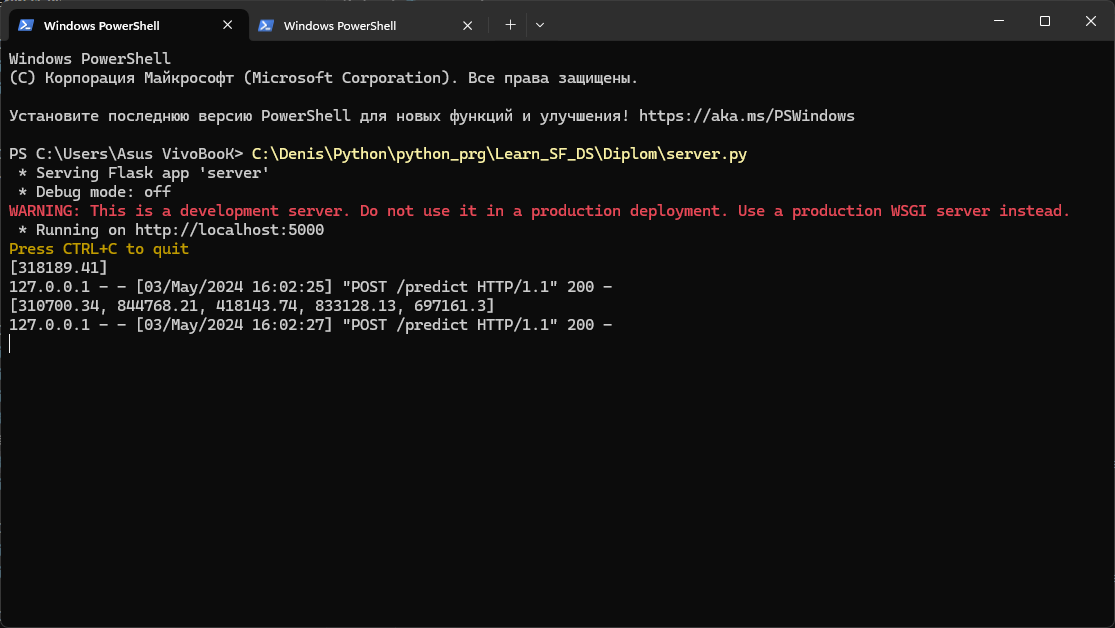

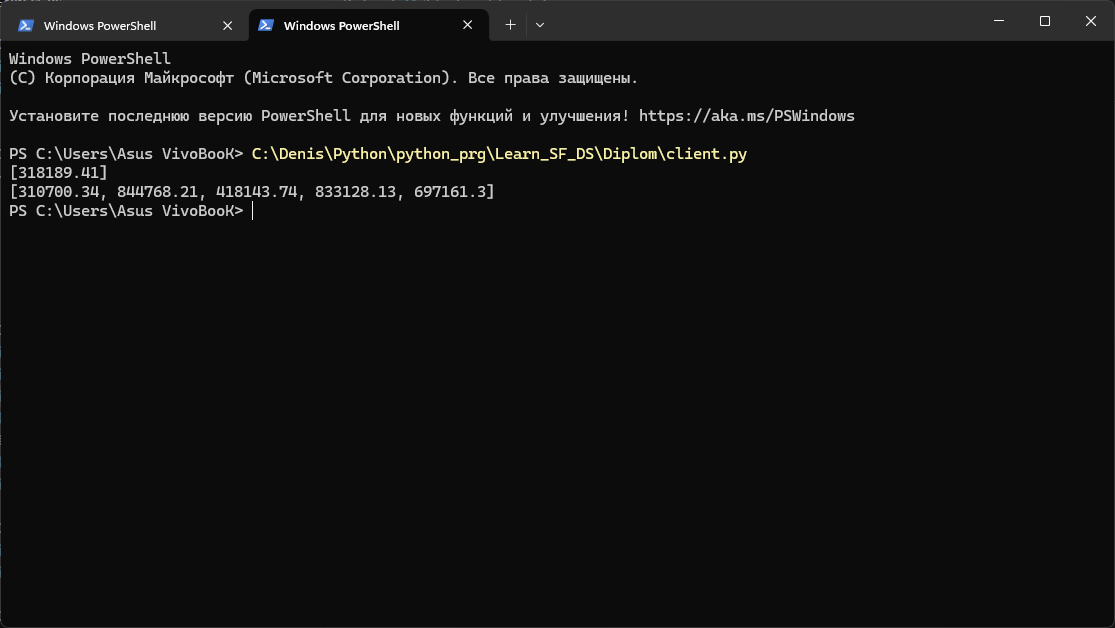